In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import editdistance
import pickle
import time

from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

from crnn_model import CRNN
from crnn_data import InputGenerator
from crnn_utils import decode
from utils.training import Logger, ModelSnapshot

Using TensorFlow backend.


### Data

In [ ]:
from data_icdar2015fst import GTUtility
gt_util_train = GTUtility('data/ICDAR2015_FST/')
gt_util_test = GTUtility('data/ICDAR2015_FST/', test=True)
gt_util = GTUtility.merge(gt_util_train, gt_util_test)
#print(gt_util)

In [2]:
from data_synthtext import GTUtility
#gt_util = GTUtility('data/SynthText/', polygon=True)

file_name = 'gt_util_synthtext_seglink.pkl'
#pickle.dump(gt_util, open(file_name,'wb'))
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)

gt_util_train, gt_util_val = GTUtility.split(gt_util, split=0.8)
#print(gt_util)

In [2]:
from data_cocotext import GTUtility
file_name = 'gt_util_cocotext_val.pkl'

with open(file_name, 'rb') as f:
    gt_util_val = pickle.load(f)

#gt_util_train, gt_util_val = GTUtility.split(gt_util, split=0.8)

### Model

In [3]:
from crnn_utils import alphabet87 as alphabet

input_width = 256
input_height = 32
batch_size = 128
input_shape = (input_width, input_height, 1)

model, model_pred = CRNN(input_shape, len(alphabet), gru=False)
experiment = 'crnn_lstm_cocotext'

#model, model_pred = CRNN(input_shape, len(alphabet), gru=True)
#experiment = 'crnn_gru_synthtext'

max_string_len = model_pred.output_shape[1]

gen_train = InputGenerator(gt_util_train, batch_size, alphabet, input_shape[:2], 
                           grayscale=True, max_string_len=max_string_len)
gen_val = InputGenerator(gt_util_val, batch_size, alphabet, input_shape[:2], 
                         grayscale=True, max_string_len=max_string_len)

NameError: name 'gt_util_train' is not defined

### Training

In [ ]:
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#optimizer = Adam(lr=0.02, epsilon=0.001, clipnorm=1.)
optimizer = Adam(lr=0.1, epsilon=0.001, clipnorm=1.)



regularizer = keras.regularizers.l2(5e-4) # None if disabled
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

# dummy loss, loss is computed in lambda layer
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

#model.summary()

model.fit_generator(generator=gen_train.generate(), # batch_size here?
                    steps_per_epoch=gt_util_train.num_objects // batch_size,
                    epochs=30,
                    validation_data=gen_val.generate(), # batch_size here?
                    validation_steps=gt_util_val.num_objects // batch_size,
                    callbacks=[
                        ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
                        #ModelSnapshot(checkdir, 1000),
                        Logger(checkdir)
                    ],
                    initial_epoch=0)

Epoch 1/30
NEW epoch

NEW epoch

432/433 [============================>.] - ETA: 0s - loss: 21.7267NEW epoch

433/433 [==============================] - 438s 1s/step - loss: 21.7169 - val_loss: 22.2391
Epoch 2/30
432/433 [============================>.] - ETA: 0s - loss: 13.1322NEW epoch

433/433 [==============================] - 427s 986ms/step - loss: 13.1253 - val_loss: 31.1976
Epoch 3/30
134/433 [========>.....................] - ETA: 4:31 - loss: 7.1842
Saving model ./checkpoints/201904030137_crnn_lstm_cocotext/weights.001000.h5
432/433 [============================>.] - ETA: 0s - loss: 5.9171NEW epoch

433/433 [==============================] - 427s 985ms/step - loss: 5.9084 - val_loss: 41.4059
Epoch 4/30
432/433 [============================>.] - ETA: 0s - loss: 3.5704NEW epoch

433/433 [==============================] - 426s 983ms/step - loss: 3.5694 - val_loss: 46.6011
Epoch 5/30
268/433 [=================>............] - ETA: 2:29 - loss: 3.4652
Saving model ./checkpoints/20

### Predict

In [ ]:
g = gen_val.generate()
d = next(g)

res = model_pred.predict(d[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

#for i in range(len(res)):
for i in range(10):
    # best path, real ocr applications use beam search with dictionary and language model
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    gt_str = d[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    #ed = levenshtein(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    # display image
    img = d[0]['image_input'][i][:,:,0].T
    plt.figure(figsize=[30,0.5])
    plt.imshow(img, cmap='gray')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    
    print('%-20s %-20s %s %0.2f' % (gt_str, res_str, ''.join(chars), ed_norm))

mean_ed /= len(res)
mean_ed_norm /= len(res)

print('\nmean editdistance: %0.3f\nmean normalized editdistance: %0.3f' % (mean_ed, mean_ed_norm))

### Test

In [6]:
model.load_weights('./checkpoints/201904090148_crnn_lstm_cocotext_pretrained_v13/')
#model.load_weights('./checkpoints/201806190711_crnn_gru_synthtext/weights.300000.h5')

OSError: Unable to open file (unable to open file: name = './checkpoints/201904090148_crnn_lstm_cocotext_pretrained_v13/weights.006.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
g = gen_val.generate()
n = 100000
#n = batch_size

mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0

j = 0
while j < n:
    d = next(g)
    res = model_pred.predict(d[0]['image_input'])

    for i in range(len(res)):
        if not j < n: break
        j += 1
        
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = d[0]['source_str'][i]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))


mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))

NEW epoch

mean editdistance             0.346
mean normalized editdistance  0.084
character recogniton rate     0.913
word recognition rate         0.853


In [7]:
%%timeit
res = model_pred.predict(d[0]['image_input'][1,None], batch_size=1)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

53.4 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
res = model_pred.predict(d[0]['image_input'][:16], batch_size=16)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

57.7 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
res

array([[[1.68708709e-07, 4.06346089e-06, 4.56196902e-09, ...,
         4.46130821e-09, 1.39466565e-07, 3.52362144e-06],
        [5.49706392e-10, 8.54253390e-10, 4.16152356e-12, ...,
         1.15981779e-12, 4.80969813e-11, 9.99038577e-01],
        [1.61714077e-12, 6.84147780e-13, 9.60940312e-14, ...,
         4.50473636e-15, 3.25810640e-13, 9.99998569e-01],
        ...,
        [8.90354481e-14, 6.38189774e-16, 4.11856345e-15, ...,
         8.20477406e-17, 2.48681435e-16, 1.00000000e+00],
        [3.07925820e-12, 4.15320413e-14, 2.41882252e-13, ...,
         9.46622592e-15, 3.66144493e-14, 1.00000000e+00],
        [1.51922332e-08, 4.65460781e-10, 1.72319325e-09, ...,
         1.38086834e-10, 7.89534549e-10, 9.99994278e-01]],

       [[1.07860607e-04, 7.09959932e-06, 6.99435592e-01, ...,
         9.88796819e-05, 6.12336919e-07, 1.23228040e-02],
        [4.01250145e-05, 1.34965638e-04, 9.16126370e-01, ...,
         1.99119972e-06, 2.57378314e-08, 1.63216591e-02],
        [2.21440866e-09, 

### Example plots

NEW epoch



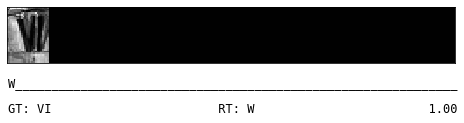

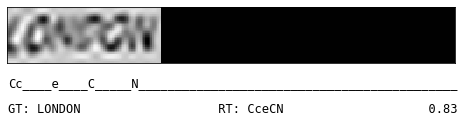

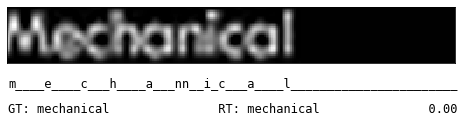

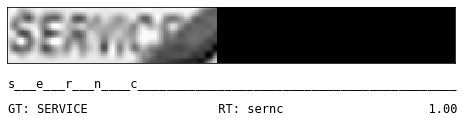

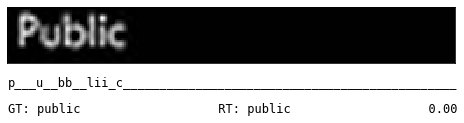

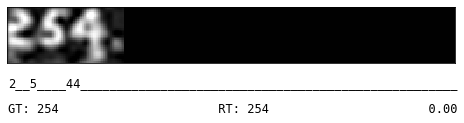

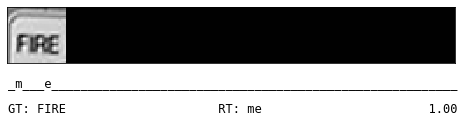

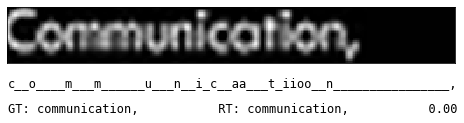

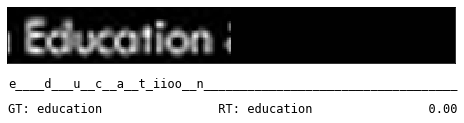

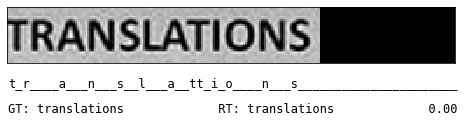

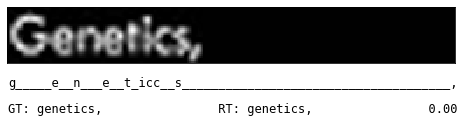

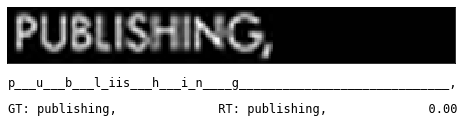

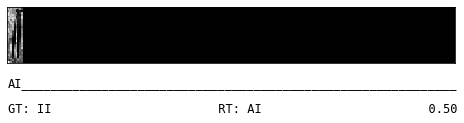

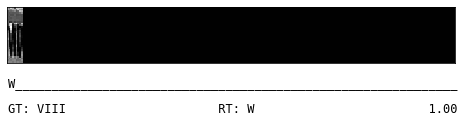

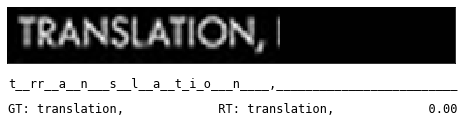

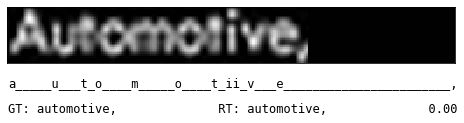

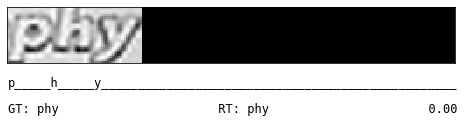

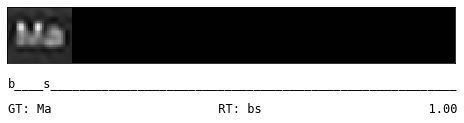

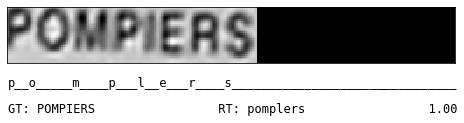

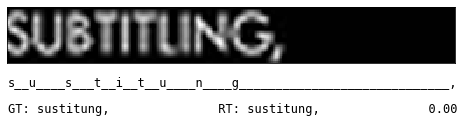

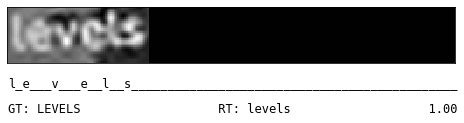

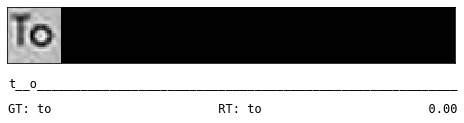

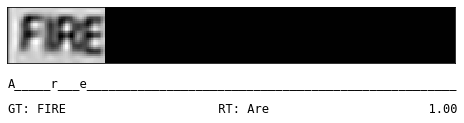

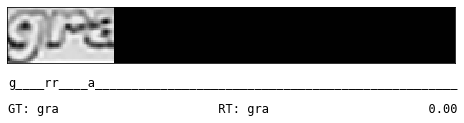

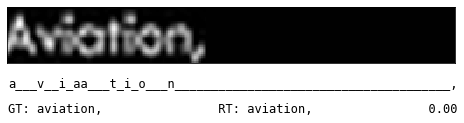

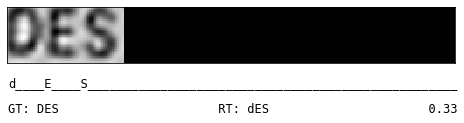

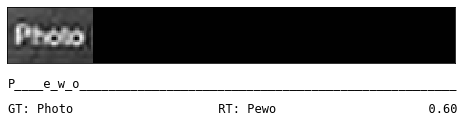

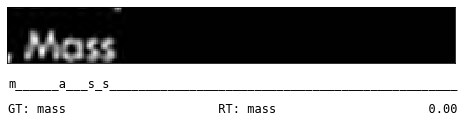

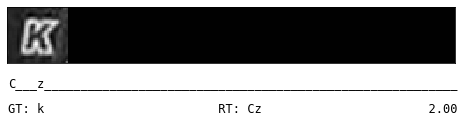

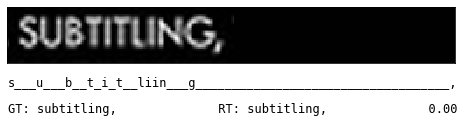

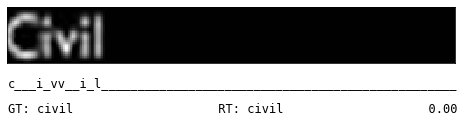

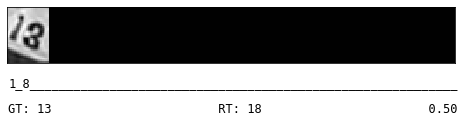

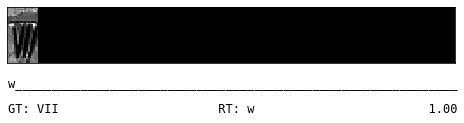

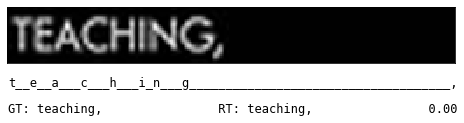

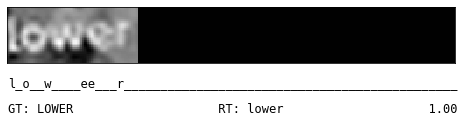

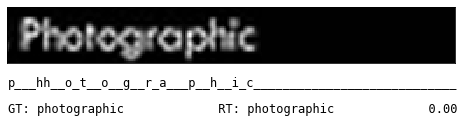

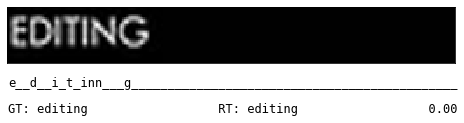

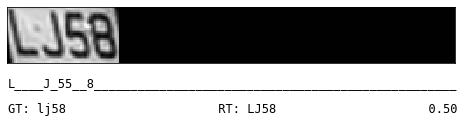

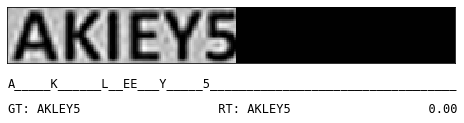

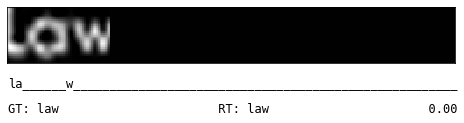


mean editdistance: 0.469
mean normalized editdistance: 0.119


In [5]:
g = gen_train.generate()
d = next(g)

res = model_pred.predict(d[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

font = {'family': 'monospace',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

plot_name = 'crnn_sythtext'

#for i in range(len(res)):
for i in range(40):
    # best path, real ocr applications use beam search with dictionary and language model
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    gt_str = d[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    #ed = levenshtein(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    # display image
    img = d[0]['image_input'][i][:,:,0].T
    plt.figure(figsize=[10,1.03])
    plt.imshow(img, cmap='gray', interpolation=None)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.text(0, 45, '%s' % (''.join(chars)), fontdict=font)
    plt.text(0, 60, 'GT: %-24s RT: %-24s %0.2f' % (gt_str, res_str, ed_norm), fontdict=font)
    
    #file_name = 'plots/%s_recogniton_%03d.pgf' % (plot_name, i)
    file_name = 'plots/%s_recogniton_%03d.png' % (plot_name, i)
    #plt.savefig(file_name, bbox_inches='tight', dpi=300)
    #print(file_name)
    
    plt.show()
    
    #print('%-20s %-20s %s %0.2f' % (gt_str, res_str, ''.join(chars), ed_norm))

mean_ed /= len(res)
mean_ed_norm /= len(res)

print('\nmean editdistance: %0.3f\nmean normalized editdistance: %0.3f' % (mean_ed, mean_ed_norm))

In [4]:
from ssd_utils import calc_memory_usage, count_parameters
crnn_lstm = CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True, gru=False)
crnn_gru = CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True, gru=True)

In [5]:
calc_memory_usage(crnn_lstm)
count_parameters(crnn_lstm)

model memory usage    41.17 MB
trainable              8745303
non-trainable             2048


In [6]:
calc_memory_usage(crnn_gru)
count_parameters(crnn_gru)

model memory usage    38.17 MB
trainable              7957847
non-trainable             2048
